# Experiments for Stance Classification
Author: Xiaochi (George) Li: [Github](https://xc-li.github.io/)  
Capstone Project for George Washington University Data Science Program Spring 2019  
Completed at [FiscalNote](https://www.fiscalnote.com/) as Data Scientist Intern

**NOTE:** The data is provided by FiscalNote and not public available. This notebook is just for demonstration purpose.

In [1]:
import pandas as pd
import numpy as np
from corpus_loader import corpus_loader, untagged_corpus_loader
import tqdm
import matplotlib.pyplot as plt
tqdm = tqdm.tqdm_notebook
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport plot_function
summary_bar = plot_function.summary_bar
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## Load Data

In [2]:
%%time
try:
    df = pd.read_pickle('./tagged_df.pickle',compression='zip')
except:
    df = corpus_loader(parser='bs')


Wall time: 200 ms


In [3]:
X = df['text']
y = df['support']
print(X.shape)

(2077,)


## Preprocess
Three methods:

1. Do nothing
2. Remove stop words (numbers and punctuation)
3. Remove stop words and lemmatization

In [4]:
# use spcay to lemmatization
import spacy
spacy = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def spacy_lemma(speech):
    doc = spacy(speech)
    return " ".join([token.lemma_ for token in doc])

# remove numbers and punctuation
import re
import string
re_number_punctuation = re.compile('['+string.punctuation+']|\d')

def remove_number_punctuation(text):
    return re.sub(re_number_punctuation, '', text.lower())

# remove stopwords
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk_stop_words = set(stopwords.words('english'))

def remove_stopwords(text, cutoff=10000):
    tokens = word_tokenize(remove_number_punctuation(text))
#     tokens = [token.strip() for token in tokens]  # no need for this line
    filtered_tokens = [token for token in tokens if token not in nltk_stop_words]
    filtered_text = ' '.join(filtered_tokens[:cutoff])
    return filtered_text

def word_count_helper(text):
    tokens = word_tokenize(remove_number_punctuation(text))
    filtered_tokens = [token for token in tokens if token not in nltk_stop_words]
    return len(filtered_tokens)

def word_count(text_array):
    count = text_array.apply(word_count_helper)
    _ = plt.hist(count, bins=100)
    return count.describe()

In [5]:
%%time 
X_remove_stopword = X.apply(remove_stopwords)

Wall time: 9.43 s


In [6]:
%%time 
X_lemmatized = X_remove_stopword.apply(spacy_lemma)

Wall time: 55.9 s


In [7]:
%%time 
X_500_remove_stopword = X.apply(remove_stopwords, cutoff=500)

Wall time: 10.8 s


In [8]:
%%time
X_500_lemmatized = X_500_remove_stopword.apply(spacy_lemma)

Wall time: 36.5 s


count    2077.000000
mean      260.343284
std       164.572041
min         9.000000
25%       108.000000
50%       207.000000
75%       439.000000
max       500.000000
Name: text, dtype: float64

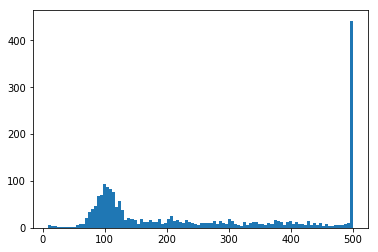

In [9]:
word_count(X_500_remove_stopword)

[1634, 443]


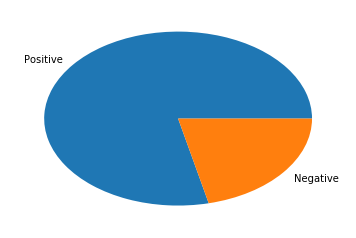

In [10]:
plt.pie([y[y==1].count(), y[y==-1].count()], labels=['Positive', 'Negative'])
print([y[y==1].count(), y[y==-1].count()])

## Experiment with Pipeline

Preprocessing
1. Do nothing --> None
2. Remove stop words (numbers and punctuation) -->RS
3. Remove stop words and lemmatization -->Lema

Vectorization:

1. Count Vectorization -->C
2. Tf-idf Vectorization -->T

Balancing the data:

1. Do nothing -->N
2. Smote -->S

\begin{equation*}
N_{experiments} = N_{Preprocessing} \times N_{Vectorization} \times N_{Balancing} \times N_{Models}
\end{equation*}

### Define the experiment pipeline to test all combinations

In [11]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
%aimport Pipeline_V1
Pipeline = Pipeline_V1.Pipeline
count = CountVectorizer()
tfidf = TfidfVectorizer()
smote = SMOTE(random_state=42)

original_logistic_regression = LogisticRegression()
%aimport plot_function
summary_bar = plot_function.summary_bar

In [12]:
def experiment_pipeline(model,X,y,X_remove_stopword,X_lemmatized):
    experiment_in = {
        # Do nothing
        'None_Count_None': Pipeline(X, y, vectorizer=count, model=model, sampler=None),
        'None_Count_Smote': Pipeline(X, y, vectorizer=count, model=model, sampler=smote),
        'None_Tfidf_None': Pipeline(X, y, vectorizer=tfidf, model=model, sampler=None),
        'None_Tfidf_Smote': Pipeline(X, y, vectorizer=tfidf, model=model, sampler=smote),
        # remove stop word
        'RS_Count_None': Pipeline(X_remove_stopword, y, vectorizer=count, model=model, sampler=None),
        'RS_Count_Smote': Pipeline(X_remove_stopword, y, vectorizer=count, model=model, sampler=smote),
        'RS_Tfidf_None': Pipeline(X_remove_stopword, y, vectorizer=tfidf, model=model, sampler=None),
        'RS_Tfidf_Smote': Pipeline(X_remove_stopword, y, vectorizer=tfidf, model=model, sampler=smote),
        # Remove stop words and Lemmatization
        'Lema_Count_None': Pipeline(X_lemmatized, y, vectorizer=count, model=model, sampler=None),
        'Lema_Count_Smote': Pipeline(X_lemmatized, y, vectorizer=count, model=model, sampler=smote),
        'Lema_Tfidf_None': Pipeline(X_lemmatized, y, vectorizer=tfidf, model=model, sampler=None),
        'Lema_Tfidf_Smote': Pipeline(X_lemmatized, y, vectorizer=tfidf, model=model, sampler=smote)
    }
    
    experiment_out = []
    for key, pipeline in tqdm(experiment_in.items()):
        report = pipeline.exec(silent=True)
        experiment_out.append([key, report['test_f1_neg'], report['test_f1_pos'], report['train_f1_neg'], report['train_f1_pos']])
    
    experiment_table = pd.DataFrame(experiment_out)
    experiment_table.columns = ['Combination', 'test_neg', 'test_pos', 'train_neg', 'train_pos']
    return experiment_table

### XGBoost

In [13]:
import xgboost as xgb  # version 0.80
xgb_original = xgb.XGBClassifier()
xgb_after_grid_search = xgb.XGBClassifier(n_estimators=550,
                                          max_depth=4,
                                          gamma=0.1,
                                          learning_rate=0.1,
                                          subsample=0.7,
                                          colsample_bytree=0.7,
                                          scale_pos_weight=0.25,
                                          #max_delta_step=4,
                                          scoring='roc_auc')

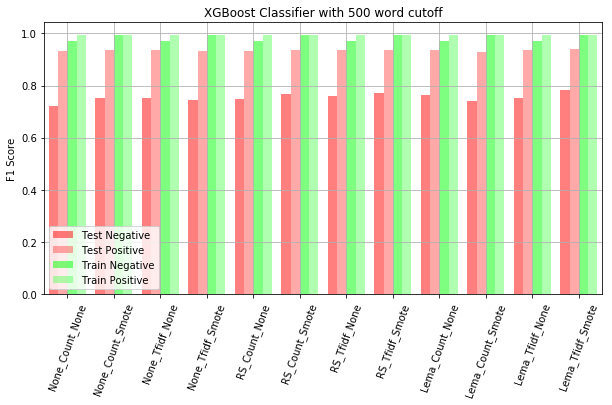

In [14]:
xgb_500_cutoff = experiment_pipeline(xgb_after_grid_search, X, y, X_500_remove_stopword, X_500_lemmatized)
summary_bar(xgb_500_cutoff, 'XGBoost Classifier with 500 word cutoff')

In [20]:
xgb_500_cutoff

,Combination,test_neg,test_pos,train_neg,train_pos
0,None_Count_None,0.721311,0.932271,0.971787,0.992063
1,None_Count_Smote,0.752941,0.936556,0.992188,0.992063
2,None_Tfidf_None,0.750988,0.936683,0.971787,0.992063
3,None_Tfidf_Smote,0.743295,0.932118,0.992188,0.992063
4,RS_Count_None,0.748092,0.933063,0.971787,0.992063
5,RS_Count_Smote,0.766284,0.938197,0.992188,0.992063
6,RS_Tfidf_None,0.758621,0.936170,0.971787,0.992063
7,RS_Tfidf_Smote,0.771536,0.937819,0.992188,0.992063
8,Lema_Count_None,0.758621,0.936170,0.971787,0.992063
9,Lema_Count_Smote,0.787879,0.943089,0.992188,0.992063


### Logistic Regression

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


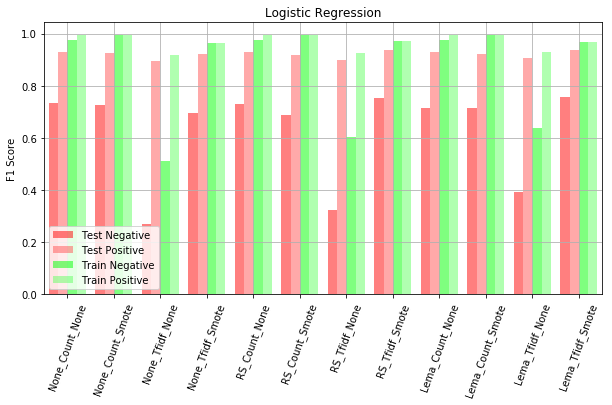

In [14]:
experiment_table = experiment_pipeline(original_logistic_regression,X, y, X_remove_stopword, X_lemmatized)
summary_bar(experiment_table, 'Logistic Regression')

In [15]:
experiment_table

,Combination,test_neg,test_pos,train_neg,train_pos
0,None_Count_None,0.732283,0.931590,0.976000,0.993424
1,None_Count_Smote,0.724528,0.925738,0.993453,0.993424
2,None_Tfidf_None,0.270968,0.896615,0.513064,0.917505
3,None_Tfidf_Smote,0.695312,0.921371,0.962768,0.962866
4,RS_Count_None,0.731518,0.930373,0.976077,0.993418
5,RS_Count_Smote,0.689922,0.919192,0.993441,0.993435
6,RS_Tfidf_None,0.325000,0.900735,0.603104,0.927088
7,RS_Tfidf_Smote,0.752000,0.937876,0.973444,0.973187
8,Lema_Count_None,0.714859,0.928929,0.976000,0.993424
9,Lema_Count_Smote,0.714286,0.922607,0.993447,0.993430


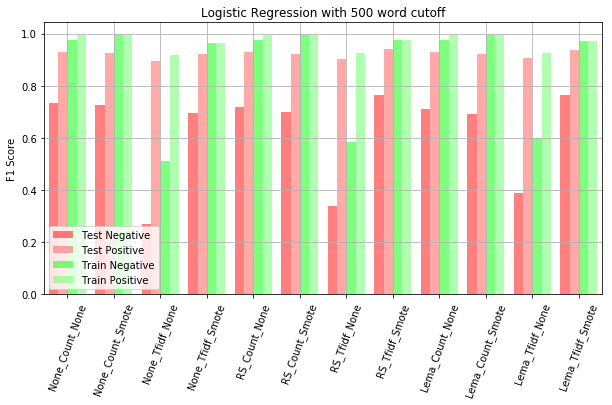

In [18]:
table_500_cutoff = experiment_pipeline(original_logistic_regression, X, y, X_500_remove_stopword, X_500_lemmatized)
summary_bar(table_500_cutoff, 'Logistic Regression with 500 word cutoff')

### Logistic Regression with L1,L2 Penalty

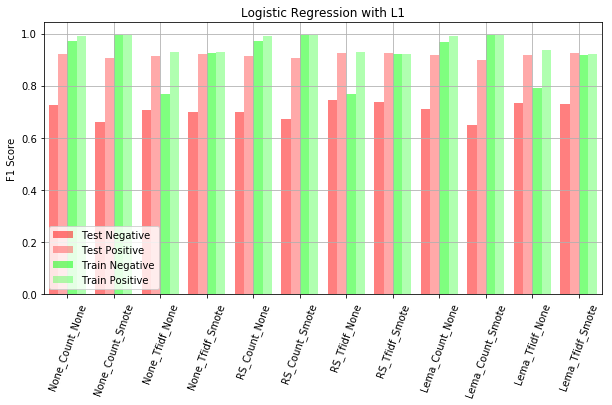

In [17]:
table_lr_l1 = experiment_pipeline(LogisticRegression(class_weight='balanced', penalty='l1'),X, y, X_remove_stopword, X_lemmatized)
summary_bar(table_lr_l1, 'Logistic Regression with L1')

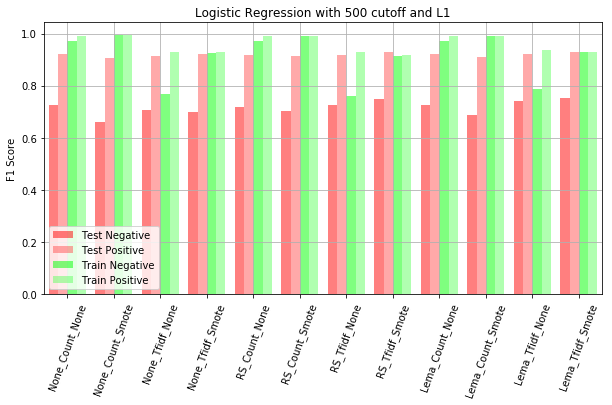

In [18]:
table_500_lr_l1 = experiment_pipeline(LogisticRegression(class_weight='balanced', penalty='l1'),X, y, X_500_remove_stopword, X_500_lemmatized)
summary_bar(table_500_lr_l1, 'Logistic Regression with 500 cutoff and L1')

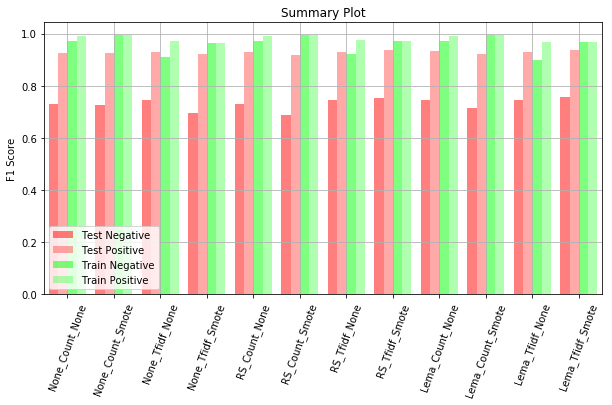

In [19]:
table_lr_l2 = experiment_pipeline(LogisticRegression(class_weight='balanced', penalty='l2', random_state=42),X, y, X_remove_stopword, X_lemmatized)
summary_bar(table_lr_l2)

### Random Forest

C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


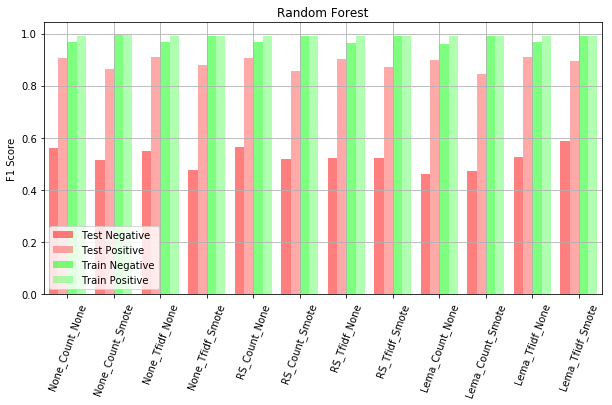

In [20]:
from sklearn.ensemble import RandomForestClassifier
table_rf = experiment_pipeline(RandomForestClassifier(random_state=42),X, y, X_remove_stopword, X_lemmatized)
summary_bar(table_rf, 'Random Forest')

In [25]:
table_rf

,Combination,test_neg,test_pos,train_neg,train_pos
0,None_Count_None,0.562212,0.907856,0.968801,0.991728
1,None_Count_Smote,0.516605,0.865916,0.993001,0.993001
2,None_Tfidf_None,0.548077,0.909615,0.968903,0.991721
3,None_Tfidf_Smote,0.476190,0.881023,0.990794,0.990834
4,RS_Count_None,0.566210,0.907677,0.968903,0.991721
5,RS_Count_Smote,0.519298,0.857736,0.990376,0.990376
6,RS_Tfidf_None,0.521327,0.902604,0.964052,0.990410
7,RS_Tfidf_Smote,0.524345,0.870540,0.992119,0.992133
8,Lema_Count_None,0.460000,0.896947,0.961983,0.990004
9,Lema_Count_Smote,0.471831,0.844398,0.991663,0.991714


C:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


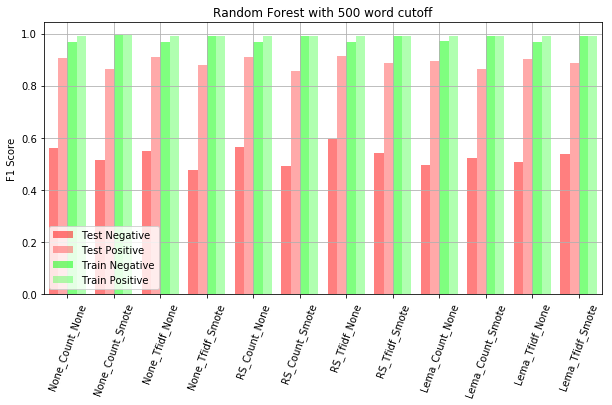

In [21]:
from sklearn.ensemble import RandomForestClassifier
table_rf_500 = experiment_pipeline(RandomForestClassifier(random_state=42),X, y, X_500_remove_stopword, X_500_lemmatized)
summary_bar(table_rf_500, 'Random Forest with 500 word cutoff')

### SVM

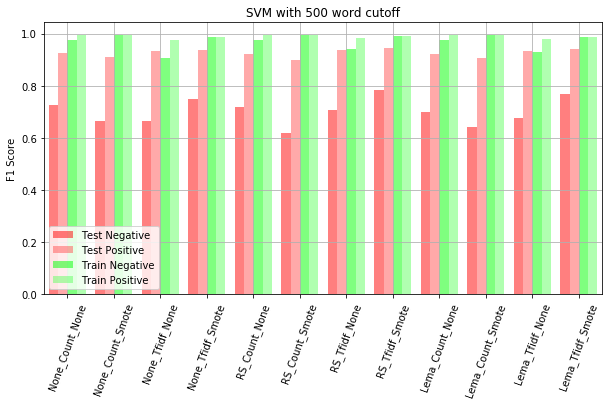

In [22]:
from sklearn.svm import SVC
table_svm_500 = experiment_pipeline(SVC(kernel='linear', probability=True, random_state=42),X, y, X_500_remove_stopword, X_500_lemmatized)
summary_bar(table_svm_500, 'SVM with 500 word cutoff')

In [26]:
table_svm_500

,Combination,test_neg,test_pos,train_neg,train_pos
0,None_Count_None,0.727273,0.926829,0.975845,0.993435
1,None_Count_Smote,0.666667,0.911854,0.993453,0.993424
2,None_Tfidf_None,0.666667,0.932563,0.905009,0.976364
3,None_Tfidf_Smote,0.748031,0.935614,0.988266,0.988111
4,RS_Count_None,0.719101,0.923547,0.975845,0.993435
5,RS_Count_Smote,0.618321,0.898580,0.993435,0.993441
6,RS_Tfidf_None,0.705882,0.936709,0.940000,0.984389
7,RS_Tfidf_Smote,0.785714,0.945783,0.989996,0.989881
8,Lema_Count_None,0.700389,0.922301,0.975845,0.993435
9,Lema_Count_Smote,0.640927,0.905966,0.993447,0.993430


<BarContainer object of 2 artists>

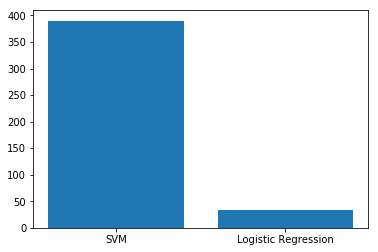

In [9]:
plt.bar([1,2],[390,34],tick_label=['SVM','Logistic Regression'])

## Mean Embedding

1. Just use Mean Embedding
2. Stack Mean Embedding after Bag of Words vector

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



   Combination  test_neg  test_pos  train_neg  train_pos
0         C=10  0.728745  0.933067   0.971008   0.970367
1          C=9  0.741036  0.934804   0.970169   0.969456
2          C=8  0.733068  0.932798   0.968494   0.967627
3          C=7  0.724409  0.929577   0.967213   0.966282
4          C=6  0.726563  0.929435   0.966321   0.965426
5          C=5  0.718750  0.927419   0.965487   0.964508
6          C=4  0.733591  0.930233   0.962036   0.960958
7          C=3  0.727969  0.928065   0.956522   0.955091
8          C=2  0.726592  0.925586   0.948552   0.947322
9          C=1  0.724014  0.920537   0.928634   0.927880
10       C=1/2  0.691275  0.903158   0.896251   0.895522
11       C=1/3  0.668919  0.897059   0.875274   0.875383
12       C=1/4  0.645161  0.882729   0.854403   0.853380
13       C=1/5  0.634615  0.878205   0.843805   0.842982


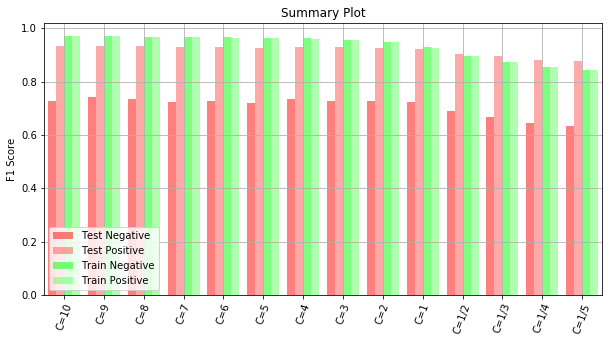

Wall time: 7min 3s


In [16]:
%%time
%aimport mean_embedding_vectorizer
pretrained = './nlpword2vecembeddingspretrained/glove.6B.300d.txt'
# mevec = mean_embedding_vectorizer.MeanEmbeddingVectorizer()
# mevec.load(pretrained)
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf = TfidfVectorizer()
stack_emb_vec = mean_embedding_vectorizer.StackedEmbeddingVectorizer(tfidf)
stack_emb_vec.load(pretrained)

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
%aimport Pipeline_V1
Pipeline = Pipeline_V1.Pipeline
count = CountVectorizer()
tfidf = TfidfVectorizer()
smote = SMOTE(random_state=42)

stack_emb_vec.set_pca(True)
# stack_emb_vec.set_vectorizer(TfidfVectorizer(min_df=0.1))
model = LogisticRegression()
p = Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=model, sampler=smote)
p.exec(silent=True)

def tune_C_experiment():
    experiment_in = {
        'C=10': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=10.0), sampler=smote),
        'C=9': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=9.0), sampler=smote),
        'C=8': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=8.0), sampler=smote),
        'C=7': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=7.0), sampler=smote),
        'C=6': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=6.0), sampler=smote),
        'C=5': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=5.0), sampler=smote),
        'C=5': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=5.0), sampler=smote),
        'C=4': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=4.0), sampler=smote),
        'C=3': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=3.0), sampler=smote),
        'C=2': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=2.0), sampler=smote),
        'C=1': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=1.0), sampler=smote),
        'C=1/2': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=1/2), sampler=smote),
        'C=1/3': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=1/3), sampler=smote),
        'C=1/4': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=1/4), sampler=smote),
        'C=1/5': Pipeline(X_lemmatized, y, vectorizer=stack_emb_vec, model=LogisticRegression(penalty='l1', C=1/5), sampler=smote)
    }
    
    experiment_out = []
    for key, pipeline in tqdm(experiment_in.items()):
        report = pipeline.exec(silent=True)
        experiment_out.append([key, report['test_f1_neg'], report['test_f1_pos'], report['train_f1_neg'], report['train_f1_pos']])
    
    experiment_table = pd.DataFrame(experiment_out)
    experiment_table.columns = ['Combination', 'test_neg', 'test_pos', 'train_neg', 'train_pos']
    return experiment_table

tune_C_table = tune_C_experiment()
print(tune_C_table)
summary_bar(tune_C_table)